# INTRODUCTION TO DATA SCIENCE - PROJECT 3#
## Rishiraj Rana##
## Daily Data Forecasting##

Data pre processing

In [64]:
!pip install prophet

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import plotly.express as px
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sys
import os
from tqdm.keras import TqdmCallback
from sklearn.model_selection import train_test_split
import json
import warnings
warnings.filterwarnings('ignore')

In [66]:
from prophet import Prophet
data = pd.read_csv('/content/SN_d_tot_V2.0.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74629 entries, 0 to 74628
Data columns (total 1 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   1818;01;01;1818.001;  -1; -1.0;   0;1  74629 non-null  object
dtypes: object(1)
memory usage: 583.2+ KB


,1818;01;01;1818.001; -1; -1.0; 0;1
0,1818;01;02;1818.004; -1; -1.0; 0;1
1,1818;01;03;1818.007; -1; -1.0; 0;1
2,1818;01;04;1818.010; -1; -1.0; 0;1
3,1818;01;05;1818.012; -1; -1.0; 0;1
4,1818;01;06;1818.015; -1; -1.0; 0;1


In [67]:
columns = ['Year', 'Month', 'Day', 'Fractional Year', 'Sunspots', 'Std Dev', 'Observations', 'Definitive']
daily_data = pd.read_csv("/content/SN_d_tot_V2.0.csv", sep=";", header=None, names=columns)
daily_data.head()

,Year,Month,Day,Fractional Year,Sunspots,Std Dev,Observations,Definitive
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1


In [68]:
daily_data = daily_data[['Year', 'Month','Day', 'Sunspots']]

daily_data.head()

,Year,Month,Day,Sunspots
0,1818,1,1,-1
1,1818,1,2,-1
2,1818,1,3,-1
3,1818,1,4,-1
4,1818,1,5,-1


In [69]:
daily_data['Date'] = pd.to_datetime(daily_data[['Year', 'Month', 'Day']])
daily_data.set_index('Date', inplace=True)
daily_data.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
daily_data.head(10)

,Sunspots
Date,
1818-01-01,-1
1818-01-02,-1
1818-01-03,-1
1818-01-04,-1
1818-01-05,-1
1818-01-06,-1
1818-01-07,-1
1818-01-08,65
1818-01-09,-1


In [70]:
mean_sunspot_number = daily_data['Sunspots'][daily_data['Sunspots'] != -1].mean()

daily_data['Sunspots'] = daily_data['Sunspots'].replace(-1, mean_sunspot_number)

daily_data.tail(10)

,Sunspots
Date,
2022-04-21,114.0
2022-04-22,110.0
2022-04-23,128.0
2022-04-24,127.0
2022-04-25,118.0
2022-04-26,132.0
2022-04-27,132.0
2022-04-28,135.0
2022-04-29,107.0


Plotting the data

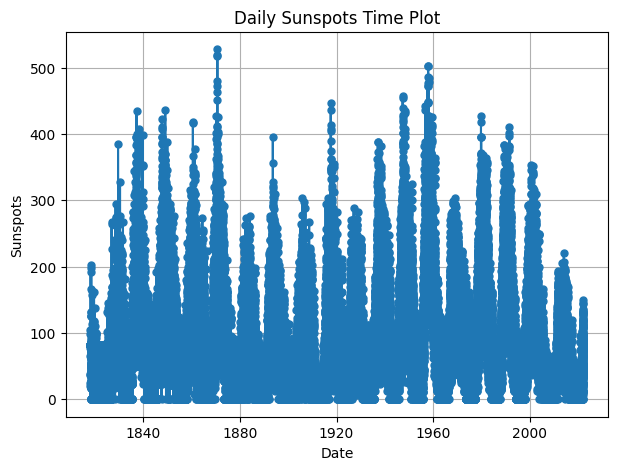

In [71]:
plt.figure(figsize=(7, 5))
plt.plot(daily_data.index, daily_data['Sunspots'], marker='o', linestyle='-', markersize=5)
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.title('Daily Sunspots Time Plot')
plt.grid(True)
plt.show()

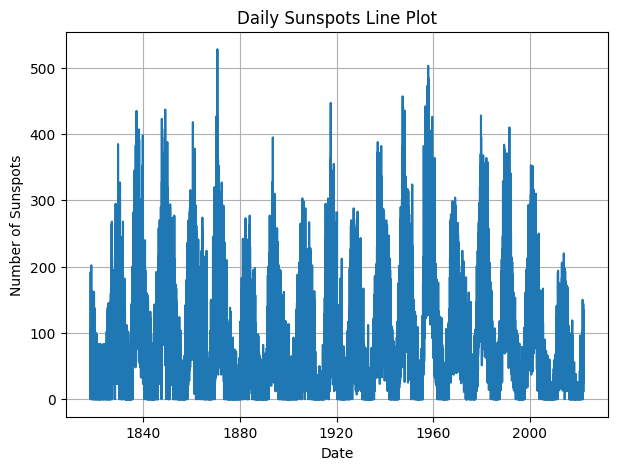

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

plt.plot(daily_data.index, daily_data['Sunspots'])
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.title('Daily Sunspots Line Plot')
plt.grid(True)
plt.show()

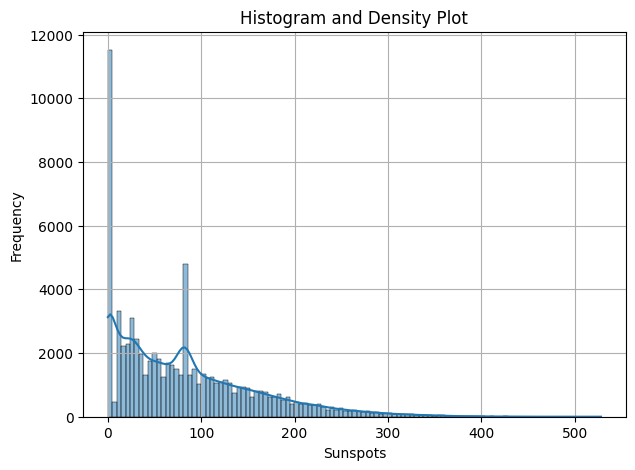

In [73]:
# Histogram and Density Plot
plt.figure(figsize=(7, 5))
# Changed data['Sunspots'] to daily_data['Sunspot Number'] as 'Sunspots' column does not exist in original data.
sns.histplot(daily_data['Sunspots'], kde=True)
plt.xlabel('Sunspots')
plt.ylabel('Frequency')
plt.title('Histogram and Density Plot')
plt.grid(True)
plt.show()

In [74]:
data.columns

Index(['1818;01;01;1818.001;  -1; -1.0;   0;1'], dtype='object')

In [75]:
daily_data = daily_data.rename(columns={'Sunspots': 'y'})
daily_data['ds'] = daily_data.index
daily_data.tail()


,y,ds
Date,,
2022-04-26,132.0,2022-04-26
2022-04-27,132.0,2022-04-27
2022-04-28,135.0,2022-04-28
2022-04-29,107.0,2022-04-29
2022-04-30,51.0,2022-04-30


In [76]:
daily_data['ds'] = pd.to_datetime(daily_data['ds'])
daily_data.tail()

,y,ds
Date,,
2022-04-26,132.0,2022-04-26
2022-04-27,132.0,2022-04-27
2022-04-28,135.0,2022-04-28
2022-04-29,107.0,2022-04-29
2022-04-30,51.0,2022-04-30


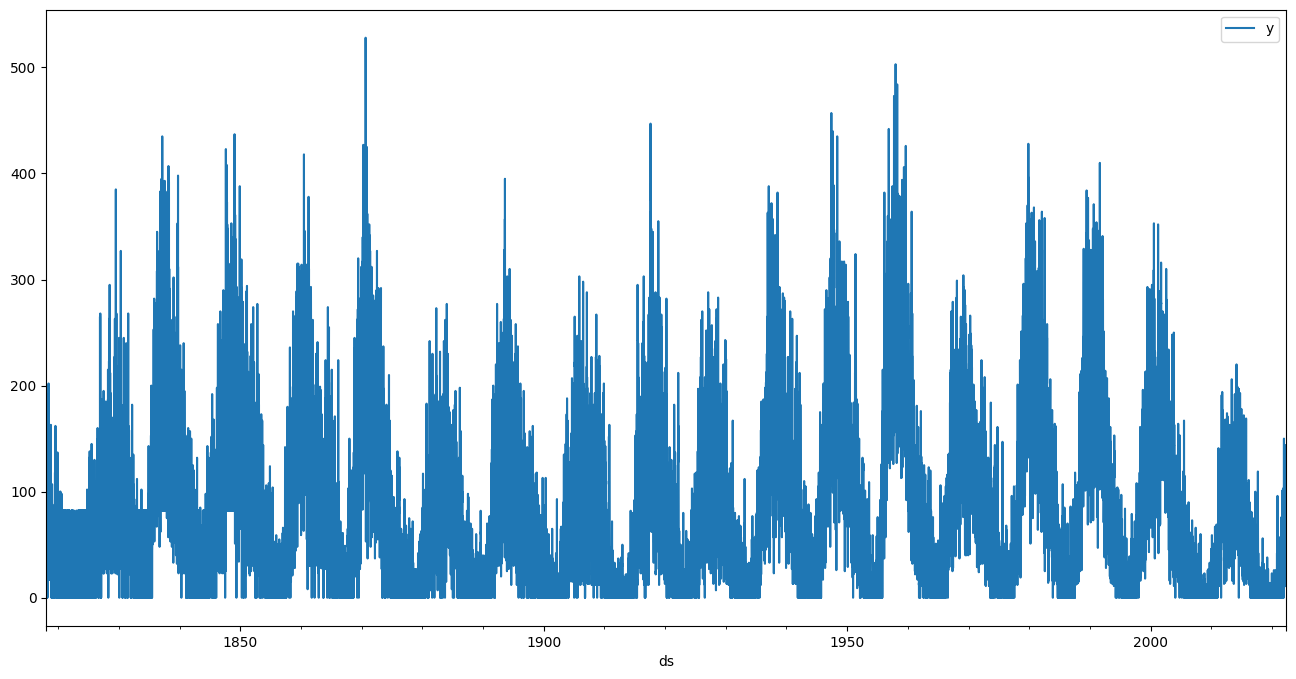

In [77]:
daily_data.plot(x='ds', y='y', figsize=(16,8))
plt.show()

Training FBProphet model

In [78]:
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

In [79]:
train = daily_data.iloc[:len(daily_data)-365]
test = daily_data.iloc[len(daily_data)-365:]

In [ ]:
model = Prophet(growth='linear', daily_seasonality=True)
model.add_seasonality(name='custom_daily', period=365.25, fourier_order=10)
model.fit(daily_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpo9gxpjv7/3ts8bn1q.json


Making predictions

In [ ]:
future = model.make_future_dataframe(periods=365, freq='D')
forecast = model.predict(future)

In [ ]:
forecast.tail()

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
test.tail()

Plotting the forecast

In [ ]:
plot_plotly(model, forecast)

In [ ]:
future_100 = model.make_future_dataframe(periods=100, freq='D')
future_200 = model.make_future_dataframe(periods=200, freq='D')
future_365 = model.make_future_dataframe(periods=365, freq='D')

forecast_100 = model.predict(future_100)
forecast_200 = model.predict(future_200)
forecast_365 = model.predict(future_365)

In [ ]:

print(forecast_365[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

plot_plotly(model, forecast_365)

In [ ]:
print(forecast_100[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
plot_plotly(model, forecast_100)


In [ ]:
print(forecast_200[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
plot_plotly(model, forecast_200)

In [ ]:
plot_components_plotly(model, forecast)

Evaluation

In [ ]:
from statsmodels.tools.eval_measures import rmse

In [ ]:
forecast_aligned = forecast[forecast['ds'].isin(test['ds'])]

min_len = min(len(test['y']), len(forecast_aligned['yhat']))
rmse_value = rmse(test['y'][:min_len], forecast_aligned['yhat'][:min_len])

print(rmse_value)

In [ ]:
forecast_aligned = forecast[forecast['ds'].isin(test['ds'])]

min_len = min(len(test['y']), len(forecast_aligned['yhat']))

predictions = forecast_aligned['yhat'][:min_len]

rmse_value = rmse(predictions, test['y'][:min_len])

print("Root mean squared error between actual and predicted values:", rmse_value)

print("mean value of the dataset: ",  test['y'].mean())

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
y_true = daily_data["y"][-365:]
y_pred = forecast["yhat"][-365:]
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("R-squared:", r2)